# Titanic

In [1]:
# DATA LIB
import pandas as pd
import numpy as np
import sklearn as sk

# TOOLS
import os
import re

# VISUALS
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# MISC
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data
df_train = pd.read_csv('~/.kaggle/competitions/titanic/train.csv')
df_test = pd.read_csv('~/.kaggle/competitions/titanic/test.csv')
df_all = pd.concat([df_train, df_test])


In [3]:
# View Data
df_all.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


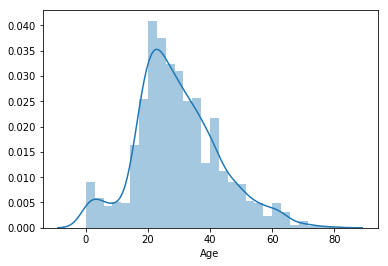

In [4]:
# Age

# Fill N/A w/fake data
age_avg = df_all['Age'].mean()
age_std = df_all['Age'].std()
fake_ages = np.random.randint(age_avg - age_std, age_avg + age_std, size=df_all['Age'].isnull().sum())
df_all['Age'][np.isnan(df_all['Age'])] = fake_ages
df_all['Age'] = df_all['Age'].astype(int)

# Bin Ages
df_all['AgeBin'] = pd.cut(df_all['Age'], 5, labels=[0, 1, 2, 3, 4])

# Plot
_ = sns.distplot(df_all['Age'].astype(float))

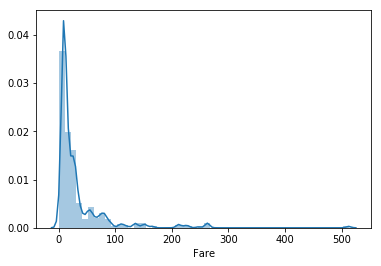

In [5]:
# Fare

# Fill N/A
df_all['Fare'] = df_all['Fare'].fillna(df_all['Fare'].median())

# Bin Ages
df_all['FareBin'] = pd.qcut(df_all['Fare'], 6, labels=[0, 1, 2, 3, 4, 5])

# Plot
_ = sns.distplot(df_all['Fare'].astype(float))

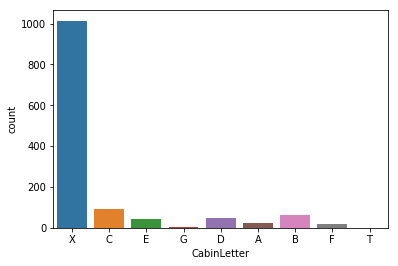

In [ ]:
# Cabin

# Cabin Prefix
df_all['CabinLetter'] = df_all['Cabin'].apply(lambda x: 'X' if type(x) == float else x[0])
cabin_dummies = pd.get_dummies(df_all['CabinLetter'], prefix='Cabin').astype(int)
df_all = pd.concat([df_all, cabin_dummies], axis=1)

# Plot Cabins
_ = sns.countplot(df_all['CabinLetter'])

In [ ]:
# Name

# Title
def extract_title(name):
    
    re_title = re.search(' ([A-Za-z]+)\.', name)
    
    if not re_title:
        return ''
    else:
        title = re_title.group(1)
        
    if title in ['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']:
        return 'Fancy'
    elif title in ['Mlle', 'Ms', 'Miss']:
        return 'Miss'
    elif title in ['Mme', 'Mrs']:
        return 'Mrs'
    else:
        return title
    
df_all['Title'] = df_all['Name'].apply(extract_title)
title_dummies = pd.get_dummies(df_all['Title'], prefix='Title').astype(int)
df_all = pd.concat([df_all, title_dummies], axis=1)

# Plot Title
_ = sns.countplot(df_all['Title'])

In [ ]:
# Ticket

# Ticket Prefix
def extract_prefix(ticket):
    
    re_ticket = re.search('([\w/\.]+) \d+', ticket)
    
    if not re_ticket:
        return ''
    else:
        prefix = re_ticket.group(1)
        
    return prefix.strip().replace("/", "").replace(".", "")

df_all['TicketPrefix'] = df_all['Ticket'].apply(extract_prefix)
df_all['TicketHasPrefix'] = df_all['TicketPrefix'].apply(lambda x: 0 if x == "" else 1)

# Plot Ticket
_ = sns.countplot(df_all['TicketHasPrefix'])

In [ ]:
# Embarked

# Fix Missing
df_all['Embarked'] = df_all['Embarked'].fillna(df_all['Embarked'].mode())

# Dummy Vars
embark_dummies = pd.get_dummies(df_all['Embarked'], prefix='Embark').astype(int)
df_all = pd.concat([df_all, embark_dummies], axis=1)

# Plot Embark
_ = sns.countplot(df_all['Embarked'])

In [ ]:
# Sex

# Map to 0/1
df_all['SexType'] = df_all['Sex'].map({'female': 0, 'male': 1}).astype(int)

# Plot Sex
_ = sns.countplot(df_all['Sex'])

In [ ]:
# Pclass and SibSp

# Traveling Party
df_all['Party'] = df_all['SibSp'] + df_all['Parch']

# Plot Party
_ = sns.countplot(df_all['Party'])

In [ ]:
# Drop Extra Columns

drop_cols = ['PassengerId', 'Age', 'Cabin', 'CabinLetter', 'Embarked', 'Sex', 'Fare', 'Name', 'Title', 'Ticket', 'TicketPrefix']
df_feat = df_all.drop(drop_cols, axis=1)

In [ ]:
# Show Correlation

plt.figure(figsize=(16,14))
_ = sns.heatmap(df_feat.corr(), cmap=plt.cm.RdBu, linewidths=0.1, vmin=-1.0, vmax=1.0, annot=True)

In [ ]:
# Split/Process Data

num_train = len(df_train)

x_cols = ['Parch', 'Pclass', 'SibSp', 'AgeBin', 'FareBin', 'Cabin_A',
           'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G',
           'Cabin_T', 'Cabin_X', 'Title_Fancy', 'Title_Master',
           'Title_Miss', 'Title_Mr', 'Title_Mrs', 'TicketHasPrefix', 'Embark_C',
           'Embark_Q', 'Embark_S', 'SexType', 'Party']

x_all = df_feat[x_cols].as_matrix()
y_all = df_feat['Survived'].as_matrix()

X_train, X_test = x_all[:num_train], x_all[num_train:]
Y_train = y_all[:num_train]


In [ ]:
# Model

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, Y_train)
clf.score(X_train, Y_train)

In [ ]:
# Save Results

survived = pd.Series(clf.predict(X_test), name="Survived")

output = pd.concat([df_test['PassengerId'], survived], axis=1)
output.to_csv("first_attempt.csv", index=False)